# License

    Jupyter notebook for computing Pi using Monte Carlo sampling
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [ ]:
#Lets have matplotlib "inline"
%matplotlib notebook

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import os
import pyopencl as cl
import numpy as np

from matplotlib import pyplot as plt

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

In [2]:
#Determine which GPU to use
os.environ["PYOPENCL_CTX"] = "1"

#Create OpenCL context
cl_ctx = cl.create_some_context()

print("Using ", cl_ctx.devices[0].name)

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

Using  GeForce 840M


In [3]:
%%cl_kernel 
__kernel void mandelbrot(__global float* output, unsigned int cols, float x0, float y0, float dx, float dy, int iterations) {
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    float x = i*dx + x0;
    float y = j*dy + y0;
    
    float2 z0 = (float2) (x, y);
    float2 z = z0;
    int k = 0;
    
    while (z.x*z.x + z.y*z.y < 25.0 && k < iterations) {
        float tmp = z.x*z.x - z.y*z.y + z0.x;
        z.y = 2*z.x*z.y + z0.y;
        z.x = tmp;
        ++k;
    }
    
    if (k < iterations) {
        output[j*cols+i] = fmod((k - log(log(sqrt(z.x*z.x+z.y*z.y))/log(5.0))/log(2.0)) / 100, 1.0);
    }
    else {
        output[j*cols+i] = 0.0f;
    }
}

In [8]:
#Set block and grid size
n = 2048
domain_size = (3*n, 2*n)
block = (8, 8)

x0 = -2
y0 = -1
dx = 3.0 / domain_size[0]
dy = 2.0 / domain_size[1]

#Allocate the output data on the GPU and on the CPU
output = np.empty((domain_size[1], domain_size[0]), dtype=np.float32)
mf = cl.mem_flags
output_gpu = cl.Buffer(cl_ctx, mf.WRITE_ONLY, output.nbytes)


#Execute program on device
mandelbrot(cl_queue, domain_size, block,\
    output_gpu, np.int32(domain_size[0]),\
    np.float32(x0), np.float32(y0), \
    np.float32(dx), np.float32(dy), \
    np.int32(1000))

#Copy data from device to host
cl.enqueue_copy(cl_queue, output, output_gpu)
pass

<IPython.core.display.Javascript object>


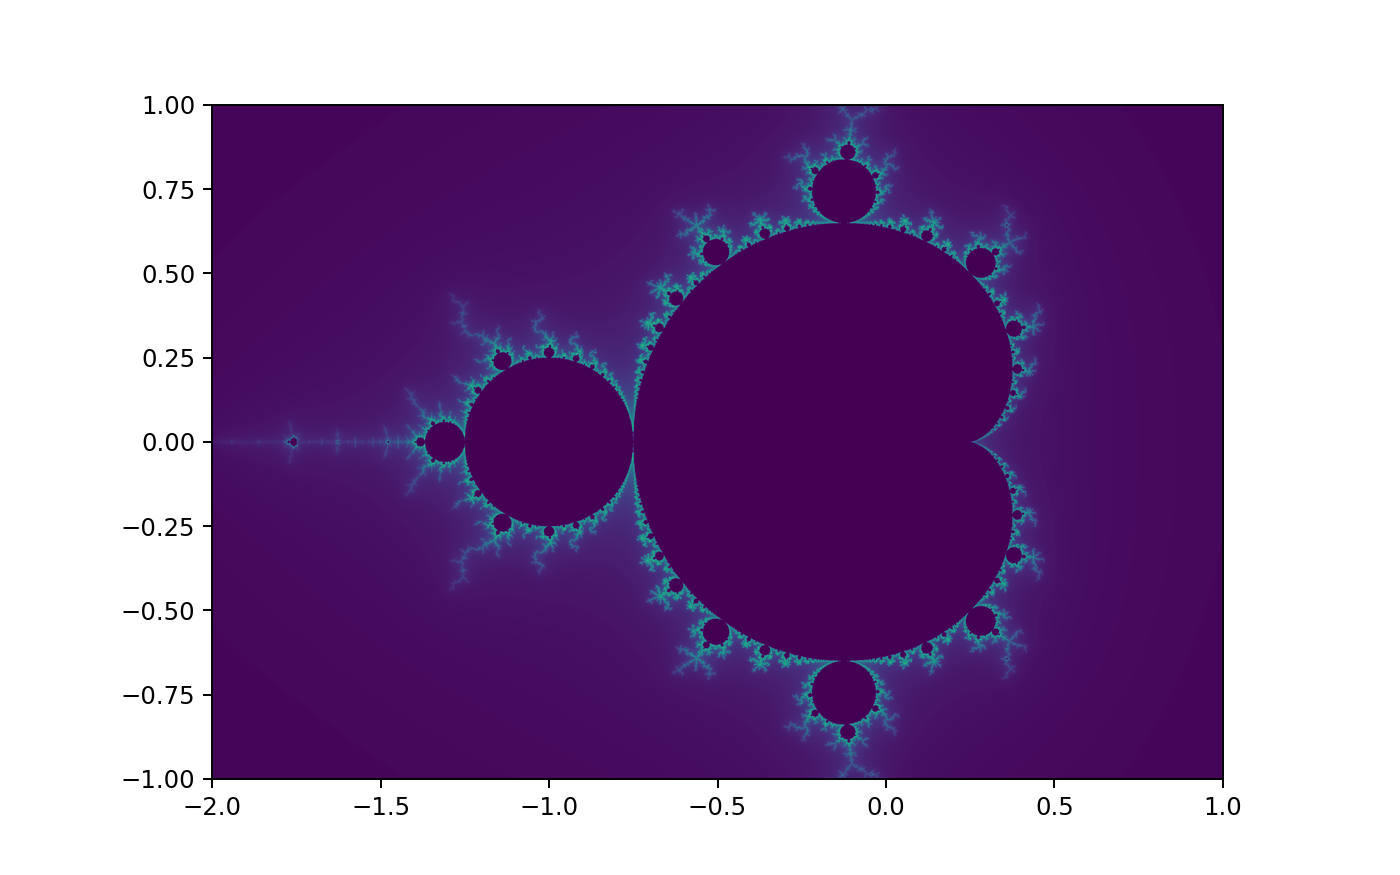

In [9]:
fig = plt.figure(figsize=(8, 5))
extent = [x0, x0+domain_size[0]*dx, y0, y0+domain_size[1]*dy]
plt.imshow(output, interpolation='spline16', origin='lower', extent=extent)
plt.show()